# 使用Keras model搭建第一個model-MNIST手寫字體分類  
>有些稍微基礎知識就先行跳過，本篇主旨在如何搭建一個model並且進行training、evaluation、inference

In [1]:
#載入所需lib
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print('TensorFlow version:', tf.__version__)
#畫圖的lib
import matplotlib.pyplot as plt

TensorFlow version: 2.2.0


MNIST是一個手寫數字的dataset，使用keras相關function就能下載。  
下載位置預設在`user/.keras/datasets/`裡面。

In [2]:
#download MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('x_train\nshape:{},data type:{}'.format(x_train.shape, x_train.dtype))
print('y_train\nshape:{},data type:{}'.format(y_train.shape, y_train.dtype))
print('x_test\nshape:{},data type:{}'.format(x_test.shape, x_test.dtype))
print('y_test\nshape:{},data type:{}'.format(y_test.shape, y_test.dtype))

x_train
shape:(60000, 28, 28),data type:uint8
y_train
shape:(60000,),data type:uint8
x_test
shape:(10000, 28, 28),data type:uint8
y_test
shape:(10000,),data type:uint8


training data 總共有60000筆 28*28 的灰階影像，testing data共有10000筆相同大小的影像。  
每個影像分別有對應的label，接下來利用這些training data訓練模型，testing data評估模型。

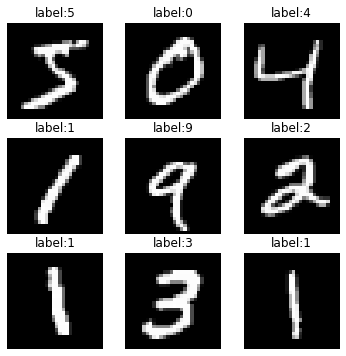

In [3]:
#輸出前九個影像以及label
plt.figure(figsize=(6, 6))
for i, (images, labels) in enumerate(zip(x_train[0:9], y_train[0:9])):
    plt.subplot(3,3, i+1)
    plt.imshow(images, cmap='gray')
    plt.title('label:{}'.format(labels))
    plt.axis('off')

In [4]:
#input layer(使用Conv2D需要3維(h, w, c)，所以上方只有(28, 28)需做處理變成(28, 28, 1)
inputs = tf.keras.Input(shape=(28, 28, 1))

# model layer
conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')
max_pool_1 = tf.keras.layers.MaxPooling2D()
conv_2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')
max_pool_2 = tf.keras.layers.MaxPooling2D()
flatten = tf.keras.layers.Flatten()
drop = tf.keras.layers.Dropout(0.5)
output = tf.keras.layers.Dense(10, activation='softmax')

# path
x = conv_1(inputs)
x = max_pool_1(x)
x = conv_2(x)
x = max_pool_2(x)
x = flatten(x)
x = drop(x)
x = output(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0     

這樣建立了一個輸入是(batch size, 28, 28, 1)的Tensor與輸出是(batch size, 10)的model。  
通常label單類別最後使用`softmax`當作activation，多類別用`sigmoid`。  
model建立好之後就可以使用提供的`fit()`、`predict()`、`evaluation()` method。

## Training model
在訓練模型之前，需要使用`model.compile(...)`設定好`loss function`、`optimizer`等東西。  
**loss function**：也叫做objective function，用來衡量**預測**與**實際**之間的差距。若選用錯的loss function可能導致model無法收斂。  
**optimizer**：調整model裡面參數的工具，裡面參數設置的好壞也直接影響model結果。  
Keras內建提供許多選用，詳細資料請查閱[loss function](https://keras.io/api/losses/)、[optimizer](https://keras.io/api/optimizers/)

In [5]:
#compile model
#sparse_categorical_crossentropy:可以直接對應數字，而不用轉換成one-hot encoding
#有些內建的function可以直接輸入名稱帶入，不然就得放置相應的function
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy']
)

將training資料進行一些處理(normalize、轉換為float32類別)

In [6]:
x_train = x_train.astype('float32') / 255
y_train = y_train.astype('float32')
x_test = x_test.astype('float32') / 255
y_test = y_test.astype('float32')

擴展維度(:, 28, 28) -> (:, 28, 28, 1)與(:)->(:,1)

In [7]:
x_train = np.expand_dims(x_train, -1)
y_train = np.expand_dims(y_train, -1)
x_test = np.expand_dims(x_test, -1)
y_test = np.expand_dims(y_test, -1)

#顯示shape與dtype
print('x_train\nshape:{},data type:{}'.format(x_train.shape, x_train.dtype))
print('y_train\nshape:{},data type:{}'.format(y_train.shape, y_train.dtype))
print('x_test\nshape:{},data type:{}'.format(x_test.shape, x_test.dtype))
print('y_test\nshape:{},data type:{}'.format(y_test.shape, y_test.dtype))

x_train
shape:(60000, 28, 28, 1),data type:float32
y_train
shape:(60000, 1),data type:float32
x_test
shape:(10000, 28, 28, 1),data type:float32
y_test
shape:(10000, 1),data type:float32


### **訓練模型**
`fit()`會保存一些紀錄(ex:epoch, loss, accuracy,...)，可以利用這些log進行圖形化分析。  
args:  
batch_size:一次丟多少檔案進去  
epochs:model需要多少次疊代(1次疊代代表看完一整個training data)  
validation系列:validation data，用來參考model是否overfitting。  
更多資訊請參閱[Model training APIs](https://keras.io/api/models/model_training_apis/)

In [8]:
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

Epoch 1/10
422/422 [==============================] - 2s 5ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.8849 - val_loss: 0.0789 - val_sparse_categorical_accuracy: 0.9783
Epoch 2/10
422/422 [==============================] - 2s 4ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.0560 - val_sparse_categorical_accuracy: 0.9858
Epoch 3/10
422/422 [==============================] - 2s 4ms/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0514 - val_sparse_categorical_accuracy: 0.9872
Epoch 4/10
422/422 [==============================] - 2s 4ms/step - loss: 0.0717 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0421 - val_sparse_categorical_accuracy: 0.9880
Epoch 5/10
422/422 [==============================] - 2s 4ms/step - loss: 0.0625 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.0419 - val_sparse_categorical_accuracy: 0.9883
Epoch 6/10
422/422 [==============================] - 2s 4ms/step - loss: 0.0558 - sparse_categorica

可以看到，經過10個epoch的訓練之後，在training data上準確度達到9成，val data上達到9成。  
現在可以來驗證一下testing data

In [9]:
score = model.evaluate(x_test, y_test)
print('test loss:', score[0])
print('test accuracy', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0284 - sparse_categorical_accuracy: 0.9912
test loss: 0.028413323685526848
test accuracy 0.9911999702453613


測試結果，在testing data上，準確度達到96.43%  
**predict的用法**
predict會直接輸出模型最後的結果，也就是10維，分別對應0~9，取最大值對應的那個類別就是預測類別。

In [10]:
#使用predict method
result = model.predict(x_test[0:9])
print('前9筆預測結果:\n',np.argmax(result, axis=-1))
print('前9筆實際值:\n', y_test[0:9].reshape(-1,).astype('int32'))

前9筆預測結果:
 [7 2 1 0 4 1 4 9 5]
前9筆實際值:
 [7 2 1 0 4 1 4 9 5]


## **總結**  
當要訓練一個model時候，定義好`輸入格式`與`輸出格式`，再將資料處理成`輸入格式`進行訓練。  
Keras主要有兩種訓練方式`fit()`與`自定義訓練`，`fit()`的好處是有很多現成的method可以使用，`自訂義`需要自己組合。  
但是在`Tensorflow 2.3`之後，可以創建`Model class`，透過修改`train_step` method來達到自訂義訓練以及使用`fit()` method的好處。